# Mixed States Reconstruction (Infidelity as loss)

In [95]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [96]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation (Haar Distribution)

In [97]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [98]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [99]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [100]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.uniform(0,1) * bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [101]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [102]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [103]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [267]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [104]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [105]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [106]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [107]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [108]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [109]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [439]:
#GENERATE DATA
data = generate_Haar_data(1, 2000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [440]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [441]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [442]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [255]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [459]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:800], bloch_vectors_with_noise[1800:1900], bloch_vectors_with_noise[1900:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:800], bloch_vectors_noise_free[1800:1900], bloch_vectors_noise_free[1900:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [460]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [461]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a*b
  return output

In [462]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(64, activation='relu')(input_layer1)
x = Dense(32, activation='relu')(x)
#x = Dense(32, activation='relu')(x)
dense_1 = Dense(units='3', name='vector', activation='sigmoid')(x)
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_147"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_148 (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 dense_157 (Dense)              (None, 64)           256         ['input_148[0][0]']              
                                                                                                  
 dense_158 (Dense)              (None, 32)           2080        ['dense_157[0][0]']              
                                                                                                  
 vector (Dense)                 (None, 3)            99          ['dense_158[0][0]']              
                                                                                          

In [463]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.00025)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=80, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 2s 54ms/step - loss: 0.1684 - val_loss: 0.1825
Epoch 2/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1679 - val_loss: 0.1819
Epoch 3/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.1673 - val_loss: 0.1813
Epoch 4/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1667 - val_loss: 0.1806
Epoch 5/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1661 - val_loss: 0.1800
Epoch 6/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1654 - val_loss: 0.1793
Epoch 7/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.1647 - val_loss: 0.1785
Epoch 8/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1640 - val_loss: 0.1778
Epoch 9/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1633 - val_loss: 0.1770
Epoch 10/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1626 - val_lo

10/10 [==============================] - 0s 12ms/step - loss: 0.0872 - val_loss: 0.0932
Epoch 82/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0869 - val_loss: 0.0930
Epoch 83/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0867 - val_loss: 0.0930
Epoch 84/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0865 - val_loss: 0.0927
Epoch 85/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0862 - val_loss: 0.0925
Epoch 86/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0860 - val_loss: 0.0923
Epoch 87/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0858 - val_loss: 0.0923
Epoch 88/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0857 - val_loss: 0.0922
Epoch 89/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0855 - val_loss: 0.0920
Epoch 90/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0853 - val_loss: 0

Epoch 161/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0826 - val_loss: 0.0900
Epoch 162/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0826 - val_loss: 0.0900
Epoch 163/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0826 - val_loss: 0.0899
Epoch 164/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0825 - val_loss: 0.0899
Epoch 165/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0825 - val_loss: 0.0898
Epoch 166/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0825 - val_loss: 0.0898
Epoch 167/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0825 - val_loss: 0.0898
Epoch 168/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0825 - val_loss: 0.0898
Epoch 169/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0825 - val_loss: 0.0898
Epoch 170/1000
10/10 [==============================] - 0s 13ms/step - lo

10/10 [==============================] - 0s 11ms/step - loss: 0.0824 - val_loss: 0.0889
Epoch 241/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0825 - val_loss: 0.0888
Epoch 242/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0824 - val_loss: 0.0888
Epoch 243/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0824 - val_loss: 0.0888
Epoch 244/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0823 - val_loss: 0.0888
Epoch 245/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0824 - val_loss: 0.0888
Epoch 246/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0824 - val_loss: 0.0888
Epoch 247/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0824 - val_loss: 0.0888
Epoch 248/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0824 - val_loss: 0.0888
Epoch 249/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0825 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0829 - val_loss: 0.0885
Epoch 320/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0828 - val_loss: 0.0884
Epoch 321/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0828 - val_loss: 0.0884
Epoch 322/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0828 - val_loss: 0.0885
Epoch 323/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0829 - val_loss: 0.0885
Epoch 324/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0829 - val_loss: 0.0885
Epoch 325/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0828 - val_loss: 0.0884
Epoch 326/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0828 - val_loss: 0.0884
Epoch 327/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0828 - val_loss: 0.0884
Epoch 328/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0828 - va

10/10 [==============================] - 0s 14ms/step - loss: 0.0831 - val_loss: 0.0883
Epoch 399/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0832 - val_loss: 0.0883
Epoch 400/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0832 - val_loss: 0.0883
Epoch 401/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0832 - val_loss: 0.0884
Epoch 402/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0831 - val_loss: 0.0882
Epoch 403/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0831 - val_loss: 0.0883
Epoch 404/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0831 - val_loss: 0.0882
Epoch 405/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0832 - val_loss: 0.0884
Epoch 406/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0833 - val_loss: 0.0883
Epoch 407/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0832 - va

10/10 [==============================] - 0s 13ms/step - loss: 0.0834 - val_loss: 0.0882
Epoch 478/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0833 - val_loss: 0.0881
Epoch 479/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0833 - val_loss: 0.0881
Epoch 480/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0833 - val_loss: 0.0882
Epoch 481/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0834 - val_loss: 0.0882
Epoch 482/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0833 - val_loss: 0.0881
Epoch 483/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0832 - val_loss: 0.0880
Epoch 484/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0833 - val_loss: 0.0881
Epoch 485/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0833 - val_loss: 0.0881
Epoch 486/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0833 - va

10/10 [==============================] - 0s 11ms/step - loss: 0.0833 - val_loss: 0.0883
Epoch 557/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0833 - val_loss: 0.0883
Epoch 558/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0834 - val_loss: 0.0884
Epoch 559/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0832 - val_loss: 0.0883
Epoch 560/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0832 - val_loss: 0.0883
Epoch 561/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0832 - val_loss: 0.0884
Epoch 562/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0833 - val_loss: 0.0884
Epoch 563/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0832 - val_loss: 0.0884
Epoch 564/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0832 - val_loss: 0.0885
Epoch 565/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0834 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0836 - val_loss: 0.0884
Epoch 636/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0837 - val_loss: 0.0885
Epoch 637/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0836 - val_loss: 0.0884
Epoch 638/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0835 - val_loss: 0.0884
Epoch 639/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0837 - val_loss: 0.0885
Epoch 640/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0837 - val_loss: 0.0885
Epoch 641/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0835 - val_loss: 0.0882
Epoch 642/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0836 - val_loss: 0.0885
Epoch 643/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0836 - val_loss: 0.0884
Epoch 644/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0836 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0839 - val_loss: 0.0883
Epoch 715/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0839 - val_loss: 0.0882
Epoch 716/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0839 - val_loss: 0.0882
Epoch 717/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0839 - val_loss: 0.0882
Epoch 718/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0839 - val_loss: 0.0882
Epoch 719/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0839 - val_loss: 0.0882
Epoch 720/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0839 - val_loss: 0.0882
Epoch 721/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0839 - val_loss: 0.0882
Epoch 722/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0839 - val_loss: 0.0881
Epoch 723/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0838 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0839 - val_loss: 0.0879
Epoch 794/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0840 - val_loss: 0.0879
Epoch 795/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0839 - val_loss: 0.0879
Epoch 796/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0840 - val_loss: 0.0879
Epoch 797/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0841 - val_loss: 0.0879
Epoch 798/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0839 - val_loss: 0.0879
Epoch 799/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0840 - val_loss: 0.0879
Epoch 800/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0839 - val_loss: 0.0879
Epoch 801/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0840 - val_loss: 0.0878
Epoch 802/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0841 - va

10/10 [==============================] - 0s 15ms/step - loss: 0.0841 - val_loss: 0.0877
Epoch 873/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0844 - val_loss: 0.0878
Epoch 874/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0842 - val_loss: 0.0876
Epoch 875/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0841 - val_loss: 0.0876
Epoch 876/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0843 - val_loss: 0.0878
Epoch 877/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0843 - val_loss: 0.0876
Epoch 878/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0841 - val_loss: 0.0877
Epoch 879/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0842 - val_loss: 0.0877
Epoch 880/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0844 - val_loss: 0.0877
Epoch 881/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0842 - va

10/10 [==============================] - 0s 13ms/step - loss: 0.0842 - val_loss: 0.0875
Epoch 952/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0844 - val_loss: 0.0874
Epoch 953/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0840 - val_loss: 0.0873
Epoch 954/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0842 - val_loss: 0.0874
Epoch 955/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0842 - val_loss: 0.0873
Epoch 956/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0841 - val_loss: 0.0873
Epoch 957/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0842 - val_loss: 0.0874
Epoch 958/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0842 - val_loss: 0.0873
Epoch 959/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0841 - val_loss: 0.0874
Epoch 960/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0840 - va

In [464]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

4/4 - 0s - loss: 0.0941 - 60ms/epoch - 15ms/step


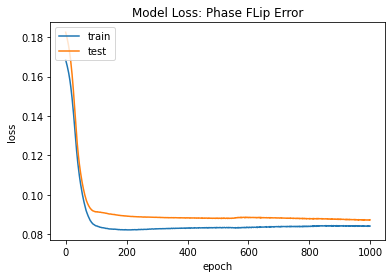

In [465]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [466]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9058753632481542-3.0764561605194155e-09j), shape=(), dtype=complex128)
